In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Business Background:
A ride-sharing company (Company X) is interested in predicting rider retention.

The dataset contains users who signed up for an account in January 2014. The data was pulled on July 1, 2014. We consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days (from the day the data was pulled).

We would like to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Company X. 

# Read in Data

In [2]:
df = pd.read_csv('data/churn.csv', parse_dates=['last_trip_date', 'signup_date'])

In [3]:
df.head()

,Unnamed: 0,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [4]:
df.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
luxury_car_user           50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


# Explore the data

In [6]:
# Customers only sighed up in January in this dataset.
df.signup_date.describe()

count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [7]:
# The last_trip_dates were from January till July.
df.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [8]:
# If the last_trip_date were earlier than '2014-06-01', we would label it with 'churn' based on the assumptions we made.
df['churn'] = (df.last_trip_date < pd.to_datetime('2014-06-01')).astype(int)

In [9]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,1
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,1
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,1


In [10]:
# General statistics infomation of all the numeric variables.
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,churn
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084,0.623920
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503,0.484405
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000,0.000000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000,1.000000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000,1.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000,1.000000


In [11]:
# surge_pct and avg_surge were highly correlated.
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
avg_dist,1.000000,0.080540,0.034509,-0.081491,-0.104414,-0.136329,0.032310,0.101652,0.092780
avg_rating_by_driver,0.080540,1.000000,0.123175,0.010597,0.020103,-0.039115,0.009343,0.020442,0.026791
avg_rating_of_driver,0.034509,0.123175,1.000000,-0.026189,-0.003899,-0.011302,-0.002086,0.014630,0.011653
avg_surge,-0.081491,0.010597,-0.026189,1.000000,0.793582,-0.001841,-0.078791,-0.110071,0.003333
surge_pct,-0.104414,0.020103,-0.003899,0.793582,1.000000,0.005720,-0.106861,-0.144918,-0.011797
trips_in_first_30_days,-0.136329,-0.039115,-0.011302,-0.001841,0.005720,1.000000,0.112210,0.050388,-0.210463
luxury_car_user,0.032310,0.009343,-0.002086,-0.078791,-0.106861,0.112210,1.000000,0.035998,-0.205002
weekday_pct,0.101652,0.020442,0.014630,-0.110071,-0.144918,0.050388,0.035998,1.000000,-0.009693
churn,0.092780,0.026791,0.011653,0.003333,-0.011797,-0.210463,-0.205002,-0.009693,1.000000


In [12]:
# From the table below, it seems that there were differences in these features between two classes:
#'avg_dist','surge_pct','trips_in_first_30_days', 'luxury_car_user'. 
# We need to do more EDA to test our obsorvations.
df.groupby('churn')['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct',\
                    'trips_in_first_30_days','luxury_car_user', 'weekday_pct'].mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
churn,,,,,,,,
0,5.114788,4.762772,4.592930,1.073809,9.152797,3.306318,0.505052,61.389034
1,6.207939,4.787464,4.607557,1.075339,8.666739,1.658482,0.299942,60.647032


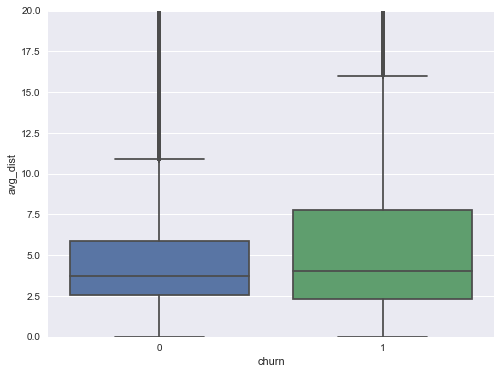

In [13]:
plt.rcParams['figure.figsize'] = (8,6)
sns.boxplot(x='churn', y='avg_dist', data=df)
plt.ylim([0,20])
plt.show()

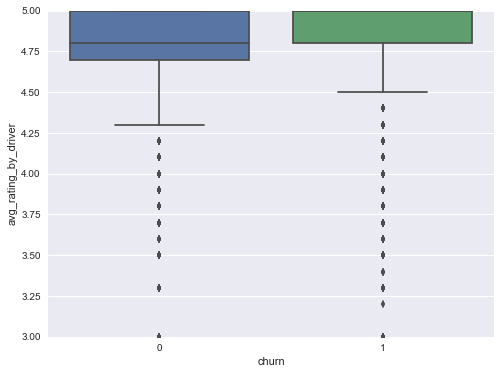

In [14]:
sns.boxplot(x='churn', y='avg_rating_by_driver', data=df)
plt.ylim([3, 5])
plt.show()

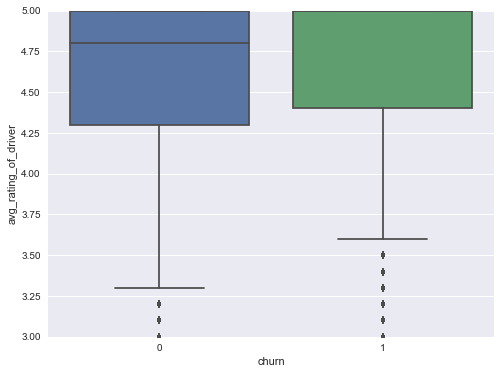

In [15]:
sns.boxplot(x='churn', y='avg_rating_of_driver', data=df)
plt.ylim([3, 5])
plt.show()

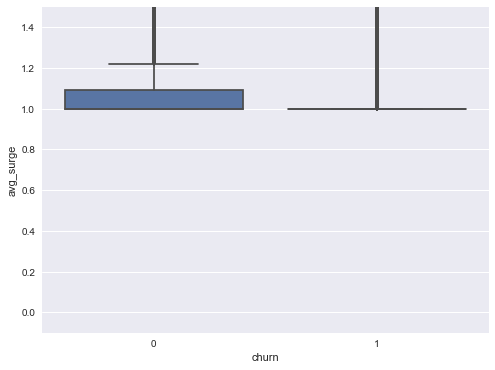

In [16]:
sns.boxplot(x='churn', y='avg_surge', data=df)
plt.ylim([-0.1,1.5])
plt.show()

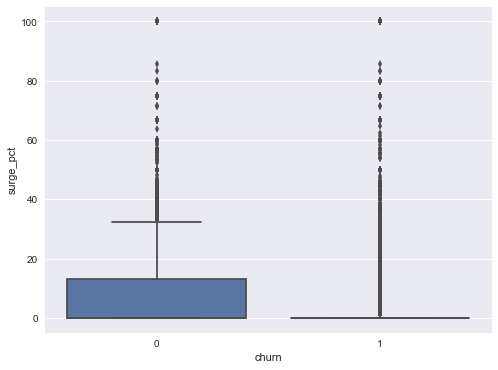

In [17]:
# highly correlated with avg_surge, we kept surge_pct in the final model.
sns.boxplot(x='churn', y='surge_pct', data=df)
plt.show()

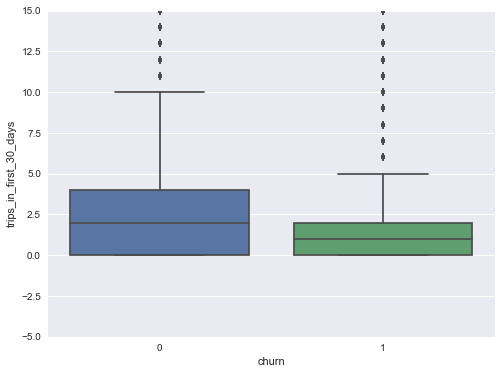

In [18]:
sns.boxplot(x='churn', y='trips_in_first_30_days', data=df)
plt.ylim([-5,15])
plt.show()

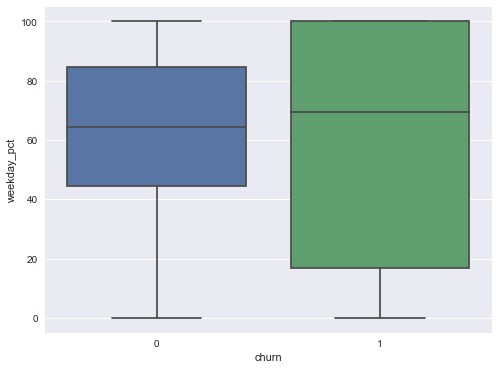

In [19]:
sns.boxplot(x='churn', y='weekday_pct', data=df)
plt.show()

In [20]:
# Now explore some categorical variables. It seems there were differnt churning rate in different cities.
df.groupby('churn').city.value_counts(normalize=True).unstack()

city,Astapor,King's Landing,Winterfell
churn,,,
0,0.224846,0.338385,0.436769
1,0.394474,0.120753,0.484774


In [21]:
# Not a good indicator for churning or not. 
df.groupby('churn').phone.value_counts(normalize=True).unstack()

phone,Android,iPhone
churn,,
0,0.168497,0.831503
1,0.383927,0.616073


In [22]:
# Customers who churned tend not to use luxury cars.
df.groupby('churn').luxury_car_user.value_counts(normalize=True).unstack()

luxury_car_user,False,True
churn,,
0,0.494948,0.505052
1,0.700058,0.299942


In [23]:
# Create dummy variables for city.
city_dummies = pd.get_dummies(df.city).iloc[:,1:]

In [24]:
# Concate city_dummies with the previous dataframe.
df_new = pd.concat([df, city_dummies], axis=1)

# Build the Model

In [25]:
# Based on the explorations above, we decided to keep the following features: 
feature_cols = ['avg_dist','trips_in_first_30_days',"King's Landing",'Winterfell','luxury_car_user', 'weekday_pct',\
               'luxury_car_user','surge_pct']

In [26]:
X = df_new[feature_cols]
y = df_new.churn

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
# Null model for the test dataset.
y_test.value_counts(normalize=True)

1    0.6216
0    0.3784
Name: churn, dtype: float64

In [29]:
gbc = GradientBoostingClassifier(n_estimators=500, max_depth=8, subsample=0.5, 
                                 max_features='auto', learning_rate=0.05)

In [30]:
cross_val_score = cross_val_score(gbc, X_train, y_train, cv=5).mean()
cross_val_score

0.76522500000000004

In [31]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=8,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=500, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [32]:
y_pred_proba = gbc.predict_proba(X_test)[:, 1]

In [33]:
# print out the metric scores of the model.
print 'Accuracy Score = {:.2f}\nRecall Score = {:.2f}\nPrecision Score = {:.2f}\nAuc Score = {:.2f}'.format\
                                                      (gbc.score(X_test, y_test), 
                                                      recall_score(y_test, gbc.predict(X_test)),
                                                      precision_score(y_test, gbc.predict(X_test)),
                                                      roc_auc_score(y_test, y_pred_proba))

Accuracy Score = 0.77
Recall Score = 0.85
Precision Score = 0.79
Auc Score = 0.83


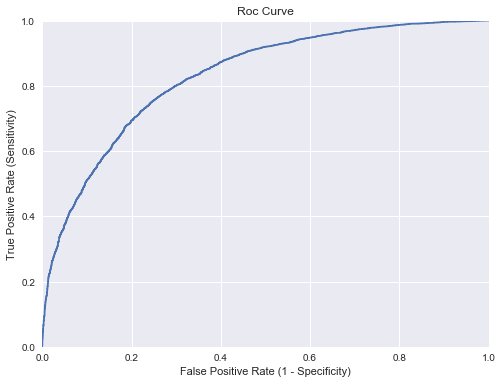

In [34]:
# Plot ROC Curve.
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Roc Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()